In [73]:
import numpy as np
import torch
import learn2learn as l2l

from torch import nn, optim
from Polynomial import Polynomial

import matplotlib.pyplot as plt
if torch.cuda.is_available():  
  dev = "cuda:1" 
else:  
  dev = "cpu"

from siren_pytorch import SirenNet

from numpy.polynomial.chebyshev import chebval3d
from adapters import fast_adapt_integral

# Generate data, task and non task specific

In [74]:
shots=20
num_tasks=1000

# Data
# RHS/source/forcing functions
test_sources = Polynomial(num_samples_per_task=2*shots, degree=10, num_tasks=num_tasks)

# Initial conditions f(0) = 0
x_0 = torch.zeros(1,1).to(dev)
f_0 = torch.zeros(1,1).to(dev)
boundary = [x_0,f_0]

# Load the model and the relevant hyperparameters

In [91]:
checkpoint = torch.load('./models/integral.pth')
adaptation_steps = checkpoint['steps']
model = SirenNet(
    dim_in = 1,                        # input dimension, ex. 2d coor
    dim_hidden = 64,                  # hidden dimension
    dim_out = 1,                       # output dimension, ex. rgb value
    num_layers = 2,                    # number of layers
    final_activation = nn.Identity(),   # activation of final layer (nn.Identity() for direct output)
    w0_initial = 3.                   # different signals may require different omega_0 in the first layer - this is a hyperparameter
).to(dev)

maml = l2l.algorithms.MAML(model, lr=0.01, first_order=False, allow_unused=True)
maml.load_state_dict(checkpoint['net'])

<All keys matched successfully>

# Plot training curves

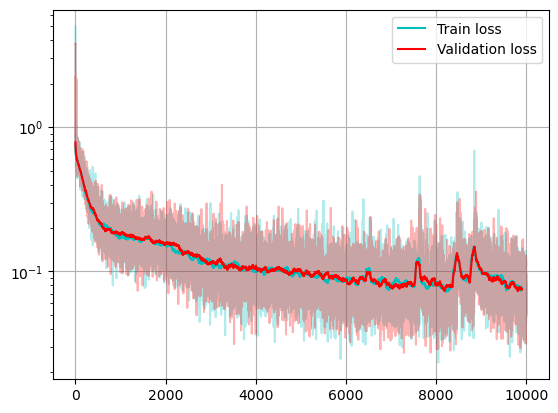

In [89]:
val_loss = np.array(checkpoint['loss_history_val'])
train_loss = np.array(checkpoint['loss_history_train'])
N=100
plt.plot(train_loss, color='c', alpha=0.3)
plt.plot(val_loss, color='r', alpha=0.3)
plt.plot(np.convolve(train_loss, np.ones(N)/N, mode='valid') ,label='Train loss', color='c')
plt.plot(np.convolve(val_loss, np.ones(N)/N, mode='valid'),label='Validation loss', color='r')

plt.legend()
plt.grid()
plt.yscale('log')

In [92]:
errors = []
x = torch.linspace(-1,1,40).reshape(-1,1)
for i in test_sources:
    poly = np.polynomial.chebyshev.Chebyshev(i.coefficients)
    y = poly(x)
    task = [x.numpy(),y.numpy()]

    learner = maml.clone()
    evaluation_loss = fast_adapt_integral(task,
                                    boundary,
                                    learner,
                                    adaptation_steps,
                                    dev)
    u_pred = learner(x.to(dev)).cpu().detach().numpy()
    u_true = poly.integ()(x)
    
    errors.append(np.abs(u_true-u_pred).mean())
print(sum(errors)/1000)

tensor(0.0111)


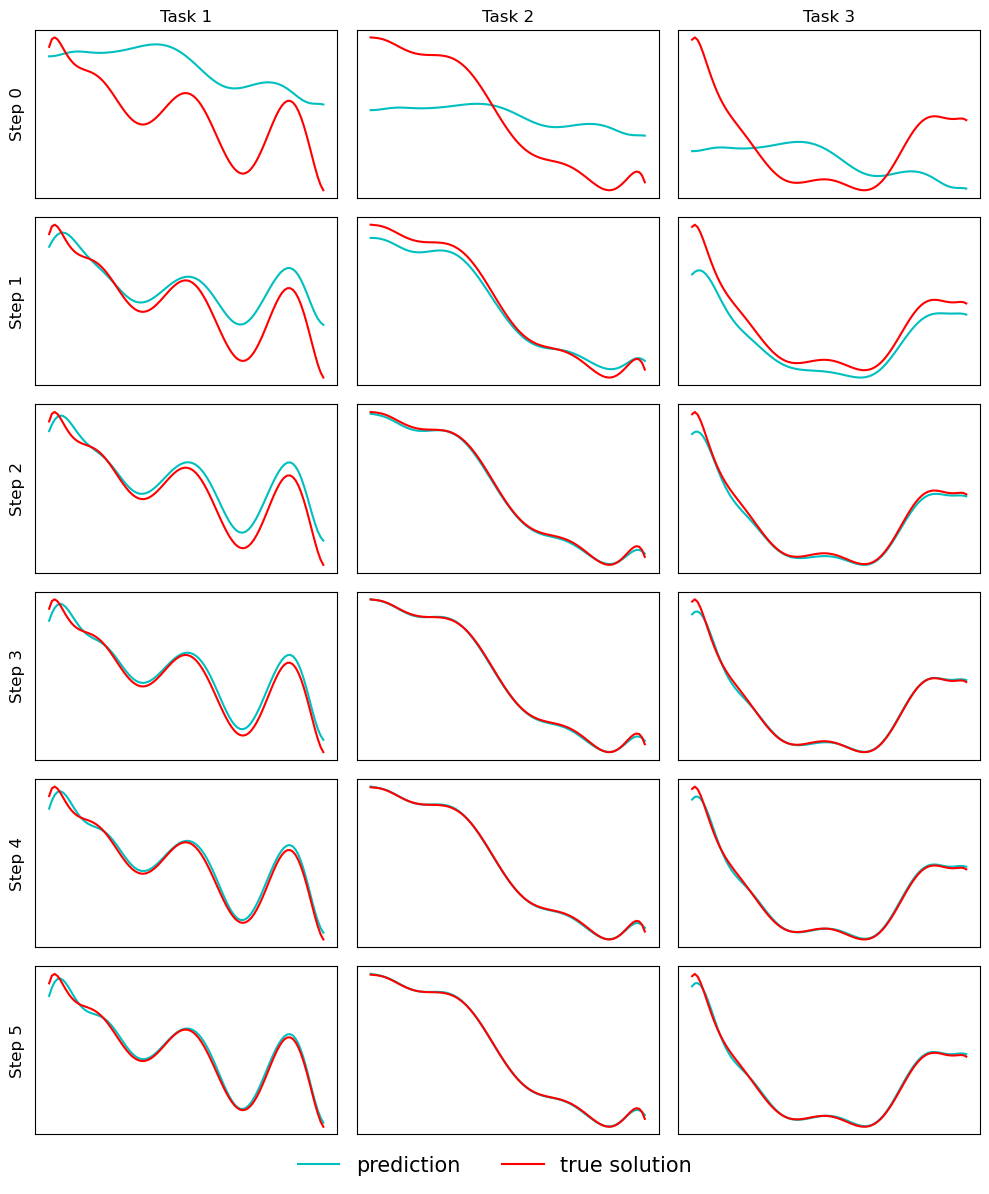

In [94]:
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["c", "r", "k"]) 
x = np.linspace(-1,1,40).reshape(-1,1)
fig, ax = plt.subplots(6, 3, figsize = (10,12))
cols = ['Task {}'.format(col) for col in range(1, 4)]
rows = ['Step {}'.format(row) for row in range(0,6)]


for axis, col in zip(ax[0], cols):
    axis.set_title(col)

for axis, row in zip(ax[:,0], rows):
    axis.set_ylabel(row, rotation=90, size='large')


for axis in ax.flatten():
    axis.set_xticks([])
    axis.set_yticks([])

for j in range(3):
    task = test_sources.sample_task()
    poly = np.polynomial.chebyshev.Chebyshev(task.coefficients)
    y = poly(x)
    
    task = [x,y]
    x_plot = torch.linspace(-1,1,100).reshape(-1,1).to(dev)
    y_true = poly.integ()(x_plot)
    learner = maml.clone()
    y_pred = learner(x_plot)
    ax[0,j].plot(y_pred.cpu().detach().numpy(), label='[rediction')
    ax[0,j].plot(y_true.cpu().detach().numpy() ,label='true')
    for i in range(adaptation_steps):
        evaluation_loss = fast_adapt_integral(task,
                                    boundary,
                                    learner,
                                    1,
                                    dev)

    
        y_pred = learner(x_plot)
        ax[i+1,j].plot(y_pred.cpu().detach().numpy() )
        ax[i+1,j].plot(y_true.cpu().detach().numpy() ,label='true')
    
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, ['prediction','true solution'], loc='lower center',ncol=2, frameon=False, prop={'size': 15})

plt.tight_layout()
fig.subplots_adjust(bottom=0.05)

In [22]:
ax[0]

TypeError: 'AxesSubplot' object is not subscriptable